# How to Perform N Times Faster Outlier Detection in UMAP (Python) on Million-row Datasets
## SUBTITLE TODO
![](images/pixabay.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://pixabay.com/users/publicdomainpictures-14/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=2205'>PublicDomainPictures</a>
        on 
        <a href='https://pixabay.com/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=2205'></a>
    </strong>
</figcaption>

# Setup

In [ ]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

# Introduction

We've all used those simple techniques - plot a scatterplot or a KDE, and the data points farthest from the group are outliers. Now, tell me - how would you use these methods if you were to find outliers in say, 100-dimensional datasets? Right off the bat, visual outlier detection methods are out of the question. So, fancy machine learning algorithms like Local Outlier Factor or Isolation Forest come to mind, which are fairly effectively against outliers that lie in high-dimensional data. 

But there are many caveats to using ML methods to detect outliers. A method called Elliptical Envelope uses a covariance estimation but assumes the data is normally distributed (which is rarely the case). Local Outlier Factor is much faster than Isolation Forest at the risk of lower accuracy. 

So, how can we excel at both speed and accuracy at outlier detection when dealing with massive, million-row datasets that are so common? That's where UMAP comes in.

# What is UMAP?

UMAP (Uniform Manifold Approximation & Projection) is a dimensionality reduction algorithm, introduced in 2018. It combines the best features of PCA and tSNE - it can scale to large datasets easily and compete with PCA in terms of speed, and project data to low dimensional space much more effectively and beautifully than tSNE:

<p float="left">
  <img src="https://miro.medium.com/max/1250/1*OMXhwgFxgwn5fLEkGrV_Pw.png" width="300" height="300"/>
  <img src="https://miro.medium.com/max/3750/1*GEeKKJET7WzzrGcWhL3H-A.png" width="300" height="300"/> 
  <img src="https://miro.medium.com/max/1250/1*rlfn-CugxKhmZ8G7sLJQJQ.png" width="300" height="300"/>
</p>

The UMAP python package has a familiar Scikit-learn API. Below is an example projecting the Kaggle TPS September Competition to 2D:

In [2]:
import datatable as dt
import pandas as pd
import umap  # pip install umap-learn

tps = dt.fread("data/train.csv").to_pandas()
tps.shape

(957919, 120)

```python
X, y = tps.drop("claim", axis=1), tps[["claim"]].values.flatten()

# Initialize the manifold
manifold = umap.UMAP(n_components=2)
manifold.fit(X, y)

X_2d = manifold.transform(X)
```

UMAP is designed so that whatever dimension you project the data to, it reserves as much variance and topological structure of the data as possible. But what does it have to do with outlier detection?

Well, since we know that UMAP preserves all the pecularities and attributes of the dataset even in lower dimensions, we can use it to first project the data to a lower space and then use any other outlier detection algorithm much faster! In the coming sections, we will look at an example of this using the above TPS September data.

> If you want to learn more about UMAP and its awesome features, I have covered it in-depth in a previous article:

https://towardsdatascience.com/beginners-guide-to-umap-for-reducing-dimensionality-and-visualizing-100-dimensional-datasets-ff5590fb17be


# Setting a baseline with pure Isolation Forest

Before we move on, let's establish a baseline performance. First, we will fit a CatBoostClassifier for a benchmark:

In [38]:
from sklearn.ensemble import IsolationForest

tps = dt.fread("data/train.csv").to_pandas()
X, y = tps.drop("claim", axis=1), tps[["claim"]].values.flatten()

In [37]:
### HIDE, wont' affect the speed


def reduce_memory_usage(X: pd.DataFrame):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    for col in X.columns:
        col_type = X[col].dtypes
        if col_type in numerics:
            c_min = X[col].min()
            c_max = X[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    X[col] = X[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    X[col] = X[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    X[col] = X[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    X[col] = X[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    X[col] = X[col].astype(np.float32)
                else:
                    X[col] = X[col].astype(np.float64)

    return X


def add_new_features(X: pd.DataFrame):
    # Calculate num and std of missing across rows
    num_missing = X.isna().sum(axis=1)
    std_missing = X.isna().std(axis=1)

    # Add new features
    X["#missing"] = num_missing
    X["std_missing"] = std_missing

    return X


X = reduce_memory_usage(X.copy())
X = add_new_features(X.copy())

In [42]:
from sklearn.pipeline import make_pipeline

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=11212128, test_size=0.1
)

pipe = make_pipeline(
    SimpleImputer(),
    cb.CatBoostClassifier(task_type="GPU", n_estimators=1000, verbose=False),
)

pipe.fit(X_train, y_train)
preds = pipe.predict_proba(X_valid)

roc_auc_score(y_valid, preds[:, 1])

0.7847255607853264

We have got a ROC AUC score of 0.784. Now, let's fit an Isolation Forest estimator to the data after imputing missing data:

In [34]:
from sklearn.impute import SimpleImputer

# Impute
X_imputed = SimpleImputer().fit_transform(X.copy())

Event though powerful, Isolation Forest has only a few parameters to tune. The most important one is `n_estimators`, which controls the number of trees to be built. We are setting to 3000 considering the dataset size.

In [35]:
%%time

# Init Isolation Forest
iso = IsolationForest(n_estimators=3000, n_jobs=9)
labels = iso.fit_predict(X_imputed)

Wall time: 48min 19s


In [36]:
np.sum(labels == -1)

2270

After waiting for about 50 minutes, we discover that Isolation Forest found 2270 outliers in the data. Let's drop those values from the training data and fit a classifier again:

In [45]:
outlier_idx = np.where(labels == -1)[0]
X_reduced = X.copy().drop(outlier_idx)
y_reduced = np.delete(y, outlier_idx)

# Impute again
X_reduced_imputed = SimpleImputer().fit_transform(X_reduced)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_reduced_imputed, y_reduced, random_state=1121218, test_size=0.1
)

clf = cb.CatBoostClassifier(task_type="GPU", n_estimators=1000, verbose=False).fit(
    X_train, y_train
)

preds = clf.predict_proba(X_valid)
roc_auc_score(y_valid, preds[:, 1])

0.7830150068211033

We got a slight drop in the performance, but that's not a sign for us to drop our efforts of finding outliers. At this point, we don't really know whether these ~2200 data points are all the outliers in the data. We don't know whether we build Isolation Forest with enough trees, as well. The worst part, we can't try the experiment again because it is too time-consuming.

That's why we will start playing smart.

# Outlier detection with UMAP combined with Isolation Forest

After we found the 2270 outliers, we didn't double-check whether they were actually outliers. Traditional visualization methods won't work, so let's try projecting the data to 2D first and plot a scatterplot:

Wall time: 13min 53s


<AxesSubplot:>

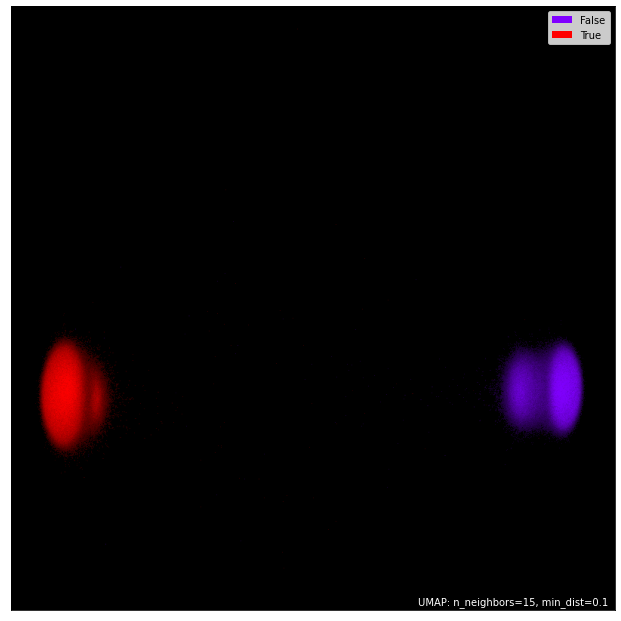

In [11]:
%%time

import umap
import umap.plot  # pip install umap-learn[plot]
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer

# Make a pipeline
pipe = make_pipeline(SimpleImputer(), QuantileTransformer())
X_processed = pipe.fit_transform(X)

# Fit the manifold and visualize
manifold = umap.UMAP().fit(X_processed, y)

umap.plot.points(manifold, labels=y, theme="fire")

We can immediately see singleton points farthest from the two distinct clusters (they are displayed in small sizes because we didn't tweak UMAP parameters). We can confidently classify these points as outliers and trust the results we obtained from Isolation Forest. 

Now, we will combine UMAP with IsolationForest. To maximize retention as much as possible, we will project the data to 5 dimensions. Then, we will fit Isolation Forest with only 500 trees, since we have much fewer features this time:

In [46]:
## HIDE

import umap
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer

In [50]:
%%time

from sklearn.ensemble import IsolationForest

# Transform the data
pipe = make_pipeline(SimpleImputer(), QuantileTransformer(), umap.UMAP(n_components=5))
X_processed = pipe.fit_transform(X)

# Fit IsolationForest and predict labels
iso = IsolationForest(n_estimators=500, n_jobs=9)
labels = iso.fit_predict(X_processed)

Wall time: 16min 22s


In [51]:
np.sum(labels == -1)

162997

The whole transformation and outlier detection took three times less amount of time. But here is the surprise - this time, Isolation Forest found a whopping ~163k outliers out of 950k. Are we making a mistake? Let's check by fitting a classifier once again after dropping these outliers:

In [52]:
outlier_idx = np.where(labels == -1)[0]
X_reduced = X.copy().drop(outlier_idx)
y_reduced = np.delete(y, outlier_idx)

# Impute again
X_reduced_imputed = SimpleImputer().fit_transform(X_reduced)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_reduced_imputed, y_reduced, random_state=1121218, test_size=0.1
)

clf = cb.CatBoostClassifier(task_type="GPU", n_estimators=1000, verbose=False).fit(
    X_train, y_train
)

preds = clf.predict_proba(X_valid)
roc_auc_score(y_valid, preds[:, 1])

0.7852876861807212

It seems that 3000 trees were not enough to find all the outliers in the data. We clearly see that even after dropping 160k observations, we are still getting the same results.

# Summary

Yes, we didn't get a significant improvement after removing outliers from the dataset. In fact, you could have said all our efforts were complete waste in terms of practicality. 

However, the purpose of this article was to show you that outlier detection will become much less time/resource-consuming when combining it powerful dimensionality reduction techniques like UMAP. As you have seen, we achieved much better performance in terms of detection with much less resources in Isolation Forests. 

Outliers are real and serious problem in the ML world. The techniques you have learned today will surely benefit you against scenarios like below, especially when you data is massive and high-dimensional:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_huber_vs_ridge_001.png)
<figcaption style="text-align: center;">
    <strong>
        Photo from Sklearn documentation
    </strong>
</figcaption>


ADD CTA